In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'This low-budget erotic thriller that has some good points, but a lot more bad one. The plot revolves around a female lawyer trying to clear her lover who is accused of murdering his wife. Being a soft-core film, that entails her going undercover at a strip club and having sex with possible suspects. As plots go for this type of genre, not to bad. The script is okay, and the story makes enough sense for someone up at 2 AM watching this not to notice too many plot holes. But everything else in the film seems cheap. The lead actors aren\'t that bad, but pretty much all the supporting ones are unbelievably bad (one girl seems like she is drunk and/or high). The cinematography is badly lit, with everything looking grainy and ugly. The sound is so terrible that you can barely hear what people are saying. The worst thing in this movie is the reason you\'re watching it-the sex. The reason people watch these things is for hot sex scenes featuring really hot girls in Red Shoe Diary si

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11,   1,   1, ...,   0,   0,   0],
       [105,  85,   1, ...,   0,   0,   0],
       [ 38, 106, 374, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'This low-budget erotic thriller that has some good points, but a lot more bad one. The plot revolves around a female lawyer trying to clear her lover who is accused of murdering his wife. Being a soft-core film, that entails her going undercover at a strip club and having sex with possible suspects. As plots go for this type of genre, not to bad. The script is okay, and the story makes enough sense for someone up at 2 AM watching this not to notice too many plot holes. But everything else in the film seems cheap. The lead actors aren\'t that bad, but pretty much all the supporting ones are unbelievably bad (one girl seems like she is drunk and/or high). The cinematography is badly lit, with everything looking grainy and ugly. The sound is so terrible that you can barely hear what people are saying. The worst thing in this movie is the reason you\'re watching it-the sex. The reason people watch these things is for hot sex scenes featuring really hot girls in Red Shoe Diary 

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[-0.00279186]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 124ms/step
[-0.00279186]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 42s 87ms/step - loss: 0.6411 - accuracy: 0.5663 - val_loss: 0.4676 - val_accuracy: 0.7823
Epoch 2/10
391/391 [==============================] - 33s 84ms/step - loss: 0.3809 - accuracy: 0.8254 - val_loss: 0.3618 - val_accuracy: 0.8453
Epoch 3/10
391/391 [==============================] - 33s 83ms/step - loss: 0.3320 - accuracy: 0.8536 - val_loss: 0.3414 - val_accuracy: 0.8510
Epoch 4/10
391/391 [==============================] - 32s 81ms/step - loss: 0.3155 - accuracy: 0.8631 - val_loss: 0.3302 - val_accuracy: 0.8562
Epoch 5/10
391/391 [==============================] - 32s 81ms/step - loss: 0.3098 - accuracy: 0.8645 - val_loss: 0.3303 - val_accuracy: 0.8562
Epoch 6/10
391/391 [==============================] - 32s 82ms/step - loss: 0.3052 - accuracy: 0.8671 - val_loss: 0.3200 - val_accuracy: 0.8542
Epoch 7/10
391/391 [==============================] - 32s 82ms/step - loss: 0.3005 - accuracy: 0.8698 - val_loss: 0.3211 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 48ms/step - loss: 0.3149 - accuracy: 0.8603
Test Loss: 0.3149417042732239
Test Accuracy: 0.8602799773216248


(0.0, 0.6582627460360527)

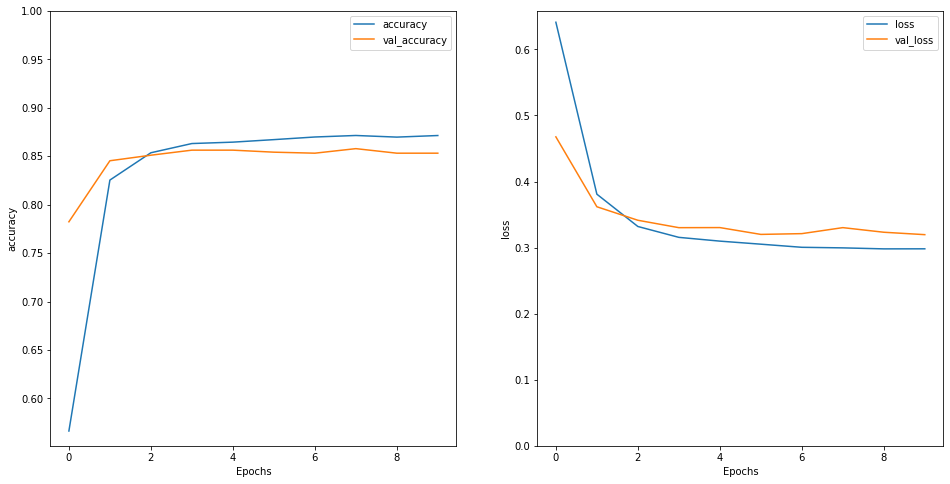

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 74s 153ms/step - loss: 0.6117 - accuracy: 0.6106 - val_loss: 0.4201 - val_accuracy: 0.8219
Epoch 2/10
391/391 [==============================] - 55s 141ms/step - loss: 0.3816 - accuracy: 0.8317 - val_loss: 0.3680 - val_accuracy: 0.8323
Epoch 3/10
391/391 [==============================] - 55s 140ms/step - loss: 0.3382 - accuracy: 0.8542 - val_loss: 0.3321 - val_accuracy: 0.8510
Epoch 4/10
391/391 [==============================] - 55s 139ms/step - loss: 0.3197 - accuracy: 0.8657 - val_loss: 0.3204 - val_accuracy: 0.8484
Epoch 5/10
391/391 [==============================] - 56s 142ms/step - loss: 0.3097 - accuracy: 0.8689 - val_loss: 0.3182 - val_accuracy: 0.8557
Epoch 6/10
391/391 [==============================] - 54s 139ms/step - loss: 0.3060 - accuracy: 0.8712 - val_loss: 0.3178 - val_accuracy: 0.8521
Epoch 7/10
391/391 [==============================] - 55s 141ms/step - loss: 0.3042 - accuracy: 0.8702 - val_loss: 0.3305 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 29s 73ms/step - loss: 0.3150 - accuracy: 0.8618
Test Loss: 0.3149975836277008
Test Accuracy: 0.861840009689331


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 4s 4s/step
[[-1.6433089]]


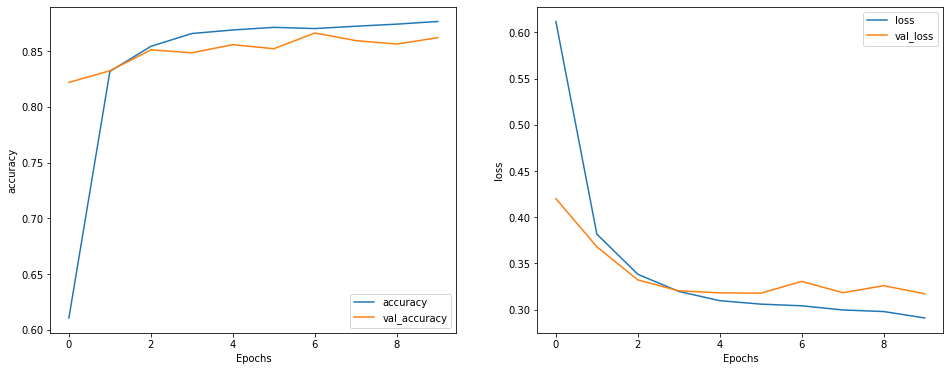

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')